In [45]:
from __future__ import print_function
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision import models, transforms
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
from functools import partial

from few_shot_learning.datasets import FashionProductImages, FashionProductImagesSmall
from few_shot_learning.utils_evaluation import ToSize
from few_shot_learning.train_transfer import transfer, validate
from few_shot_learning.utils import restore_model, allocate_inputs, allocate_model, accuracy
from config import DATA_PATH

# 1. Data Preprocessing and Statistics

Preprocessing and loading of image samples and label information is accomplished through the classes `FashionProductImages` and `FashionProductImagesSmall`. Important arguments are `split` and `classes`. For the purposes of transfer learning, the split should be one of `split='train'` or `split='test'` and the classes one of `classes='top'` or `classes='bottom'` selecting the top 20 classs with the most samples or the remaining 123 classes.

In [46]:
all_data = FashionProductImagesSmall(DATA_PATH, split='all', classes=None)

The complete dataset description looks like this:

In [47]:
all_data.df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,productDisplayName2,filename,my_id,class_id
0,0,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,NaN,15970.jpg,15970,104
1,1,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,NaN,39386.jpg,39386,56
2,2,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,NaN,59263.jpg,59263,140
3,3,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,NaN,21379.jpg,21379,128
4,4,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,NaN,53759.jpg,53759,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44441,44436,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,NaN,17036.jpg,17036,19
44442,44437,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,NaN,6461.jpg,6461,39
44443,44438,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,NaN,18842.jpg,18842,134
44444,44439,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,NaN,46694.jpg,46694,91


In [48]:
datasets = dict()

for classes in ['top', 'bottom', None]:
    
    datasets[classes] = dict()
    
    for split in ['train', 'test', 'all']:
        
        dataset = FashionProductImages(DATA_PATH, split=split, classes=classes, transform=ToSize())
        size = len(dataset)
        loader = DataLoader(dataset, batch_size=size, shuffle=False, num_workers=8)
        
        # use loader to efficiently load all images using multiple workers
        #for widths_heights, labels in loader:
        #    break
        
        #widths, heights = widths_heights
        #widths = widths.numpy()
        #heights = heights.numpy()
        #labels = labels.numpy()
        
        datasets[classes][split] = dict(data=dataset,
                                        #size=size,
                                        loader=loader,
                                        #widths=widths,
                                        #heights=heights,
                                        #labels=labels)
                                       )


### Distribution of image sizes and aspect ratios

We first have a look at the image format and sizes. It turns out they're half-way regular, mostly 1800-by-1200 pixels or 2400-by-1800 pixels, mostly RGB. Aspect ratio is almost always $4/3$. The resolution is quite high, I chose to convert all images of the full dataset to **400-by-300 pixels** (not shown here).

In [49]:
from matplotlib.colors import LogNorm

unique_heights = np.unique(datasets['top']['train']['heights'])
unique_widths = np.unique(datasets['top']['train']['widths'])
print(unique_heights)
print(unique_widths)

plt.figure(figsize=(12,9))
plt.hist2d(
    datasets['top']['train']['heights'],
    datasets['top']['train']['widths'],
    bins=[unique_heights, unique_widths],
    norm=LogNorm(),
)
plt.xticks(unique_heights)
plt.yticks(unique_widths)
plt.colorbar()
plt.show()

KeyError: 'heights'

In [50]:
aspect_ratios = datasets['top']['train']['heights']/datasets['top']['train']['widths']
unique_aspect_ratios = np.unique(aspect_ratios)
print(unique_aspect_ratios)
print((aspect_ratios == 4/3).sum())

plt.figure(figsize=(8,6))
plt.hist(aspect_ratios)
plt.show()

KeyError: 'heights'

## Distribution of classes

The distribution of labels in the training and test set is crucial. For the chosen master split, all training samples are from *even* years and all test samples are from *odd* years.

The histogram below illustrates that the distribution of class labels is quite different between training and test set. The most striking difference is the class `'Perfume and Body Mist'` which is **absent from the training set**. Similarly but less concerning is the fact that some classes are almost absent from the test set (classes `'Watches'` and `'Sunglasses'`)

The situation is worse for the remaining 123 classes. There we observe a substantial mismatch between the class distributions of training and test set, as shown below.

In [51]:
def get_mapped_class_dist(dataset, classes, normed=False):
    class_dist = np.bincount(dataset.target_indices, minlength=len(classes))
    
    if normed:
        class_dist = class_dist / class_dist.sum()
        
    class_indices = dataset.target_codec.transform(classes)
    
    return class_dist[class_indices]
    

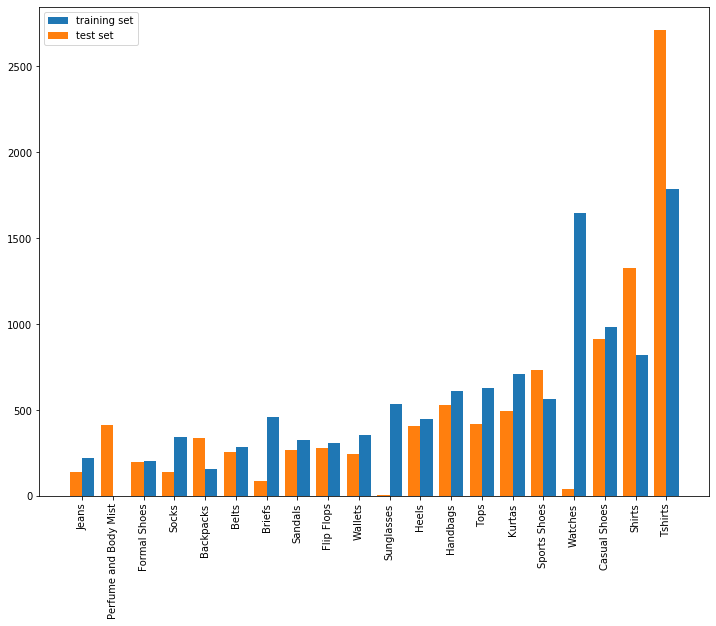

In [52]:
# top 20 classes
top20 = FashionProductImages.top20_classes

plt.figure(figsize=(12,9))
plt.bar(top20, get_mapped_class_dist(datasets['top']['train']['data'], top20), label='training set', width=0.4, align='edge')
plt.bar(top20, get_mapped_class_dist(datasets['top']['test']['data'], top20), label='test set', width=-0.4, align='edge')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

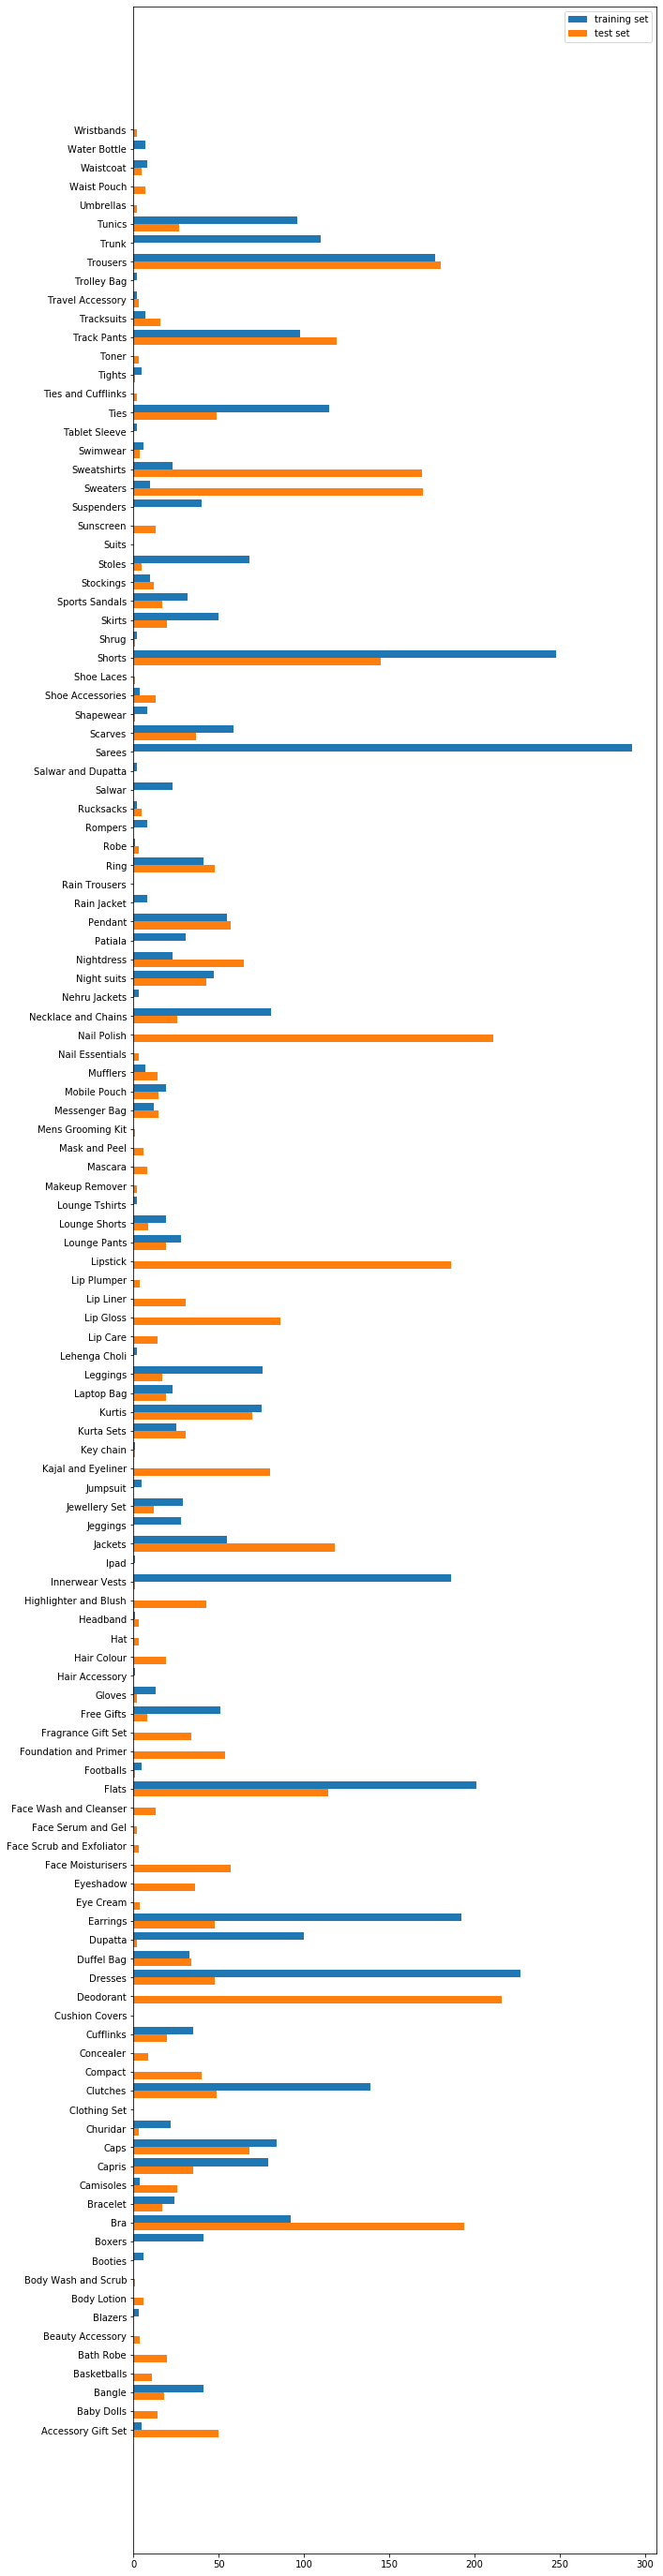

In [53]:
bottom123 = datasets['bottom']['train']['data'].target_codec.classes_

bottom_train_dist = get_mapped_class_dist(datasets['bottom']['train']['data'], bottom123)
bottom_test_dist =get_mapped_class_dist(datasets['bottom']['test']['data'], bottom123)

plt.figure(figsize=(10,50))
plt.barh(bottom123, bottom_train_dist, label='training set', height=0.4, align='edge')
plt.barh(bottom123, bottom_test_dist, label='test set', height=-0.4, align='edge')
# plt.xticks(rotation='vertical')
plt.legend()
plt.show()

Classes not present in the training set while present in the test set and their relative proportion in the test set:

In [54]:
print(bottom123[(bottom_test_dist > 0) & (bottom_train_dist == 0)])

# proportion of test samples affected
print(bottom_test_dist[(bottom_test_dist > 0) & (bottom_train_dist == 0)].sum() / bottom_test_dist.sum())

['Baby Dolls' 'Basketballs' 'Bath Robe' 'Beauty Accessory' 'Body Lotion'
 'Body Wash and Scrub' 'Compact' 'Concealer' 'Deodorant' 'Eye Cream'
 'Eyeshadow' 'Face Moisturisers' 'Face Scrub and Exfoliator'
 'Face Serum and Gel' 'Face Wash and Cleanser' 'Foundation and Primer'
 'Fragrance Gift Set' 'Hair Colour' 'Hat' 'Highlighter and Blush'
 'Kajal and Eyeliner' 'Lip Care' 'Lip Gloss' 'Lip Liner' 'Lip Plumper'
 'Lipstick' 'Makeup Remover' 'Mascara' 'Mask and Peel' 'Mens Grooming Kit'
 'Nail Essentials' 'Nail Polish' 'Shoe Laces' 'Sunscreen'
 'Ties and Cufflinks' 'Toner' 'Umbrellas' 'Waist Pouch' 'Wristbands']
0.3501259445843829


Furthermore, there are classes present in the training set which are absent from the test set.

In [55]:
# classes not present in the test set while present in the training set
print(bottom123[(bottom_test_dist == 0) & (bottom_train_dist > 0)])

['Blazers' 'Booties' 'Boxers' 'Hair Accessory' 'Ipad' 'Jeggings'
 'Jumpsuit' 'Lehenga Choli' 'Lounge Tshirts' 'Nehru Jackets' 'Patiala'
 'Rain Jacket' 'Rompers' 'Salwar' 'Salwar and Dupatta' 'Sarees'
 'Suspenders' 'Tablet Sleeve' 'Trolley Bag' 'Trunk' 'Water Bottle']


Finally, there are classes which are missing from both training and test set. These are classes that nominally have samples in `styles.csv` but whose images are missing from folder `images/`. They won't affect neither training nor testing in any way.

In [56]:
# classes neither in the training set nor test set
print(bottom123[(bottom_test_dist == 0) & (bottom_train_dist == 0)])

['Clothing Set' 'Cushion Covers' 'Rain Trousers' 'Suits']


# 2. Training

A training run can also be started via e.g.

```
python -m experiments.transfer_learning -a resnet50 -p 50 --distributed --date --epochs 100
```


In [ ]:
transfer(
    data_dir=DATA_PATH,
    architecture='resnet50',
    num_workers=8,
    epochs=100,
    batch_size=64,
    learning_rate=1e-3,
    optimizer_cls=torch.optim.Adam,
    print_freq=50,
    resume=False,
    evaluate=False,
    seed=None,
    distributed=True,
    date_prefix=True,
    model_dir=os.path.expanduser("~/few-shot-learning/models"),
    log_dir=os.path.expanduser("~/few-shot-learning/logs")
)

# 3. Evaluation

### Monitoring Training

In [58]:
LOG_DIR = os.path.expanduser("~/few-shot-learning/logs/")
MODEL_DIR = os.path.expanduser("~/few-shot-learning/models/")

folder = "19_10_08_1917"

In [59]:
finetuning_results = torch.load(os.path.join(LOG_DIR, folder, "finetuning_training_log.json"))
transfer_results = torch.load(os.path.join(LOG_DIR, folder, "transfer_training_log.json"))

In [61]:
finetuning_best_model = torch.load(
    os.path.join(MODEL_DIR, folder, "finetuning_model_best.pth.tar"),
    map_location=torch.device('cpu'))
transfer_best_model = torch.load(
    os.path.join(MODEL_DIR, folder, "transfer_model_best.pth.tar"),
    map_location=torch.device('cpu')
)

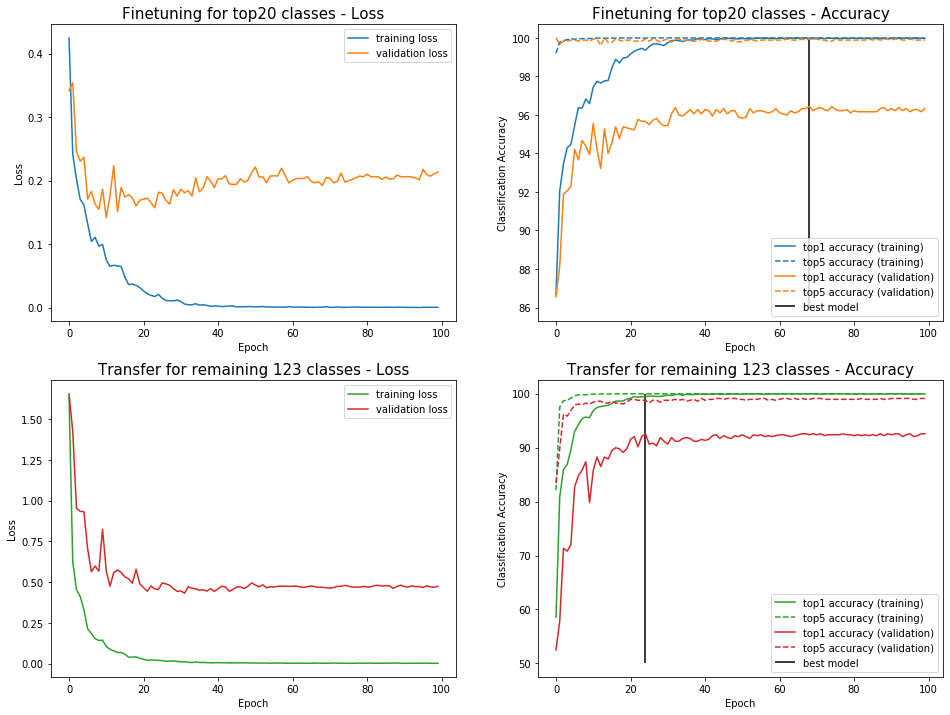

In [62]:
#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors

plt.figure(figsize=(16,12))

plt.subplot(221)
plt.plot(finetuning_results["train_loss"], label="training loss")
plt.plot(finetuning_results["val_loss"], label="validation loss")
plt.title("Finetuning for top20 classes - Loss", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(222)
plt.plot(finetuning_results["train_acc1"], label="top1 accuracy (training)", color='#1f77b4')
plt.plot(finetuning_results["train_acc5"], label="top5 accuracy (training)", color='#1f77b4', linestyle="--")
plt.plot(finetuning_results["val_acc1"], label="top1 accuracy (validation)", color='#ff7f0e')
plt.plot(finetuning_results["val_acc5"], label="top5 accuracy (validation)", color='#ff7f0e', linestyle="--")
plt.vlines(finetuning_best_model["epoch"]-1, 86, 100, label="best model")
plt.title("Finetuning for top20 classes - Accuracy", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy")
plt.legend()

plt.subplot(223)
plt.plot(transfer_results["train_loss"], label="training loss", color='#2ca02c')
plt.plot(transfer_results["val_loss"], label="validation loss", color='#d62728')
plt.title("Transfer for remaining 123 classes - Loss", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(224)
plt.plot(transfer_results["train_acc1"], label="top1 accuracy (training)", color='#2ca02c')
plt.plot(transfer_results["train_acc5"], label="top5 accuracy (training)", color='#2ca02c', linestyle="--")
plt.plot(transfer_results["val_acc1"], label="top1 accuracy (validation)", color='#d62728')
plt.plot(transfer_results["val_acc5"], label="top5 accuracy (validation)", color='#d62728', linestyle="--")
plt.vlines(transfer_best_model["epoch"]-1, 50, 100, label="best model")
plt.title("Transfer for remaining 123 classes - Accuracy", fontsize=15)
plt.xlabel("Epoch")
plt.ylabel("Classification Accuracy")
plt.legend()

plt.show()

The above plots show the training and validation losses and accuracies over the course of training.

### Performance on Test Set

In [75]:
transform = transforms.Compose([
    transforms.Resize((400, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

testset = FashionProductImages(DATA_PATH, classes="top", split="test", transform=transform)

test_loader = DataLoader(testset,
                         batch_size=128,
                         shuffle=False,
                         num_workers=8)

In [ ]:
# TODO put this into a function
model = models.resnet50()
n_features = model.fc.in_features
model.fc = nn.Linear(n_features, testset.n_classes)
model = allocate_model(dtype=None, distributed=False, gpu=None, architecture="resnet50", model=model)
model.load_state_dict(finetuning_best_model["state_dict"])



In [ ]:
allocate_inputs_ = partial(allocate_inputs, None, False, None)

model.eval()

outputs = []
targets = []

with torch.no_grad():
    # end = time.time()
    for i, (images, target) in enumerate(test_loader):
        images, target = allocate_inputs_(images, target)

        # compute output
        output = model(images)
        # loss = criterion(output, target)
        
        outputs.append(output)
        targets.append(target)

outputs = torch.cat(outputs)
targets = torch.cat(targets)

In [ ]:
acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
acc1_avg = acc1.item()
acc5_avg = acc5.item()

print(acc1_avg, acc5_avg)

In [ ]:
acc1_classwise = np.zeros(testset.n_classes) # [0.0 for _ in range(testset.n_classes)]
acc5_classwise = np.zeros(testset.n_classes) # [0.0 for _ in range(testset.n_classes)]

for c in range(testset.n_classes):
    is_class = (targets == c)
    acc1, acc5 = accuracy(outputs[is_class, :], targets[is_class], topk=(1, 5))
    acc1_classwise[c] = acc1.item()
    acc5_classwise[c] = acc5.item()


In [ ]:
plt.figure(figsize=(12,9))
plt.bar(top20 + ["All classes"], list(acc1_classwise[testset.target_codec.transform(top20)]) + [0.0], label='Top 1 Accuracy', width=-0.4, align='edge')
plt.bar(top20 + ["All classes"], list(acc5_classwise[testset.target_codec.transform(top20)]) + [0.0], label='Top 5 Accuracy', width=0.4, align='edge')
plt.bar(top20 + ["All classes"], list(np.zeros_like(acc1_classwise)) + [acc1_avg], label='Top 1 Accuracy (All Classes)', width=-0.5, align='edge')
plt.bar(top20 + ["All classes"], list(np.zeros_like(acc5_classwise)) + [acc5_avg], label='Top 5 Accuracy (All Classes)', width=0.5, align='edge')
plt.xticks(rotation='vertical')
plt.legend(loc="lower right")
plt.show()

In [ ]:
testset = FashionProductImages(DATA_PATH, classes="bottom", split="test", transform=transform)

test_loader = DataLoader(testset,
                         batch_size=128,
                         shuffle=False,
                         num_workers=8)

model = models.resnet50()
n_features = model.fc.in_features
model.fc = nn.Linear(n_features, testset.n_classes)
model = allocate_model(None, True, None, "resnet50", model)
model.load_state_dict(transfer_best_model["state_dict"])

allocate_inputs_ = partial(allocate_inputs, None, True, None)

In [ ]:
model.eval()

outputs = []
targets = []

with torch.no_grad():
    # end = time.time()
    for i, (images, target) in enumerate(test_loader):
        images, target = allocate_inputs_(images, target)

        # compute output
        output = model(images)
        # loss = criterion(output, target)
        
        outputs.append(output)
        targets.append(target)

outputs = torch.cat(outputs)
targets = torch.cat(targets)

In [ ]:
acc1, acc5 = accuracy(outputs, targets, topk=(1, 5))
acc1_avg = acc1.item()
acc5_avg = acc5.item()

print(acc1_avg, acc5_avg)

In [ ]:
acc1_classwise = np.zeros(testset.n_classes)
acc5_classwise = np.zeros(testset.n_classes)

for c in range(testset.n_classes):
    is_class = (targets == c)
    if is_class.any():
        acc1, acc5 = accuracy(outputs[is_class, :], targets[is_class], topk=(1, 5))
        acc1_classwise[c] = acc1.item()
        acc5_classwise[c] = acc5.item()
    else:
        acc1_classwise[c] = -1.0
        acc5_classwise[c] = -1.0

In [ ]:
bottom123 = list(testset.target_codec.classes_)

plt.figure(figsize=(10,50))
plt.barh(bottom123 + ["All classes"], list(acc1_classwise[testset.target_codec.transform(bottom123)]) + [0.0], label='Top 1 Accuracy', height=0.4, align='edge')
plt.barh(bottom123 + ["All classes"], list(acc5_classwise[testset.target_codec.transform(bottom123)]) + [0.0], label='Top 5 Accuracy', height=-0.4, align='edge')
plt.barh(bottom123 + ["All classes"], list(np.zeros_like(acc1_classwise)) + [acc1_avg], label='Top 1 Accuracy (All Classes)', height=0.5, align='edge')
plt.barh(bottom123 + ["All classes"], list(np.zeros_like(acc5_classwise)) + [acc5_avg], label='Top 5 Accuracy (All Classes)', height=-0.5, align='edge')
plt.legend(loc="upper left")
plt.show()